## In this notebook we will explore and process the dataset and implement ML models for classifying images based on text

### 1. ETL : We will process the data 
### 2. ML : Different machine learning model implementation

In [31]:
# Import libraries
import pandas as pd
import numpy as np
import demoji
import nltk
import os

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import multioutput
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
#ML models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pickle
import re,string

# deep learnig models
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout,SpatialDropout1D
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")

In [23]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/sanket/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sanket/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sanket/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
demoji.download_codes()

... OK (Got response in 0.97 seconds)
Writing emoji data to /home/sanket/.demoji/codes.json ...
... OK


## ETL
### In this part we will explore the data, processing and feature extraction before diving into the ML side

In [25]:
def strip_all_entities(text):
    entity_prefixes = ['@','@_','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [26]:
def print_accuracy(y_pred,y_test):
    print('Accuracy: ',np.mean(pred == np.array(y_test)))

In [27]:
# This class is used to process the data.
class DataProcessing:
    def __init__(self,df):
        '''
        Input
        df: datafame
        Initialize the class instance object variable df with data frame
        '''
        self.df = df
    
    def extract_img_url(self,df):
        '''
        extract image names
        '''
        df['urls'] = df['urls'].apply(lambda x: x[0].split('/')[-1]if len(x)>0 else np.nan)
        self.df = df
        
    def extract_thumbnail_url(self,df):
        '''
        extract thumbnail names
        '''
        df['thumbnail_src'] = df['thumbnail_src'].apply(lambda x: x.split('/')[-1])
        self.df = df
        
        
    def drop_column(self,df,cols=None):
        '''
        Input
        cols = list of columns to be dropped
        '''
        df.drop(cols, axis=1,inplace=True)
        self.df = df
    
    def extract_text(self,df):
        '''We
        extract text from caption after removing \n
        '''
        df['edge_media_to_caption'] = df['edge_media_to_caption'].apply(lambda x: demoji.
                                                                    replace(x['edges'][0]['node']['text']) 
                                                                    if len(x['edges']) > 0 else np.nan )
        df['edge_media_to_caption'] = df['edge_media_to_caption'].apply(lambda x:x.replace("\n"," ") if x!=np.nan else x)
        self.df = df
    
    def process_tags(self,df):
        '''
        convert tag list into a string separated by space
        '''
        df['tags'] = df['tags'].apply(lambda x: list(x))
        df['tags'] = df['tags'].apply(lambda x: ' '.join(x))
        self.df = df
    
    def keep_rows(self,df,images):
        '''
        remove rows that doesn't have images(that doesn't have labels) 
        '''
        df = df[df['thumbnail_src'].isin(images)]
        self.df = df
        
    def add_label(self):
        '''
        Add label values(1 for pavbhaji otherwise 0)
        '''
        self.df['pavbhaji']=np.nan
        self.df['pavbhaji'] = self.df['thumbnail_src'].apply(lambda x: 1 if x in pavbhaji_images else 0)
        
    def extract_caption(self,df):
        '''
        Remove # and @ from caption
        '''
        df['caption'] = df['edge_media_to_caption'].apply(lambda x: strip_all_entities(x))
        self.df = df
    
    def add_tag_and_caption(self,df):
        '''
        combine tags and caption into a string
        '''
        df['text'] = df['tags']+ " " + df['caption']
        self.df = df

In [28]:
# Read the json
df = pd.read_json('dataset/pavbhaji.json')

In [29]:
# Read the images from directory
pavbhaji_images = os.listdir('dataset/images/0')
nopavbhaji_images = os.listdir('dataset/images/1')
all_images = pavbhaji_images + nopavbhaji_images

In [9]:
print('Pavbhaji Images:',len(pavbhaji_images),'No Pavbhaji Images:',len(nopavbhaji_images))
print('Total Images',len(pavbhaji_images+nopavbhaji_images))

Pavbhaji Images: 269 No Pavbhaji Images: 183
Total Images 452


In [32]:
df.head()

,dimensions,display_url,edge_liked_by,edge_media_preview_like,edge_media_to_caption,edge_media_to_comment,id,is_video,location,owner,shortcode,tags,taken_at_timestamp,thumbnail_resources,thumbnail_src,urls,video_view_count,comments_disabled
0,"{'height': 734, 'width': 640}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/352...,{'count': 3797},{'count': 3797},{'edges': [{'node': {'text': 'TAG A PAV BHAJI ...,{'count': 52},1834712933156555776,True,None,{'id': '1919686029'},Bl2NbElnIva,"[vadapav, foodgram, foodphotography, foodblogg...",1532934873,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/cb5...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/89...,0.0,NaN
1,"{'height': 750, 'width': 750}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/b0d...,{'count': 12041},{'count': 12041},{'edges': [{'node': {'text': 'देसी स्टाइल पाव ...,{'count': 325},1826000656302706176,True,"{'has_public_page': True, 'id': '245717485', '...",{'id': '1445587278'},BlXQewejY3Z,"[healthyfood, sokolkata, mumbaifoodie, faridab...",1531897016,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/ad3...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/9c...,0.0,NaN
2,"{'height': 800, 'width': 640}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/cb4...,{'count': 3544},{'count': 3544},{'edges': [{'node': {'text': 'Pav Bhaji😍😍😋\n.\...,{'count': 18},1849962218902145792,True,"{'has_public_page': True, 'id': '213724095', '...",{'id': '4759392841'},BmsYtYpjkq4,"[foodphotography, mumbaipeople, vascom, delhib...",1534752790,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/64f...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/5e...,0.0,NaN
3,"{'height': 937, 'width': 750}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/180...,{'count': 1388},{'count': 1388},{'edges': [{'node': {'text': 'Asli Makhan Pav ...,{'count': 91},1828963273137213696,True,"{'has_public_page': True, 'id': '234730336', '...",{'id': '4628040416'},BlhyGgalFDw,"[foodvideo, misscravingbuster, foodblogger, mu...",1532249632,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/802...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/33...,0.0,NaN
4,"{'height': 936, 'width': 750}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/5ee...,{'count': 223},{'count': 223},{'edges': [{'node': {'text': 'Tag a Pav bhaji ...,{'count': 14},1852265507774756864,True,None,{'id': '7798081590'},Bm0kapkn3ha,[],1535027282,"[{'config_height': 150, 'config_width': 150, '...",https://instagram.fpnq3-1.fna.fbcdn.net/vp/292...,[https://instagram.fpnq3-1.fna.fbcdn.net/vp/6a...,0.0,NaN


In [11]:
df.shape

(1500, 18)

As we can see, dataframe has 1500 rows but we only have labels for 452 so we need to remove rest of the entries from dataframe.

In [33]:
df.columns

Index(['dimensions', 'display_url', 'edge_liked_by', 'edge_media_preview_like',
       'edge_media_to_caption', 'edge_media_to_comment', 'id', 'is_video',
       'location', 'owner', 'shortcode', 'tags', 'taken_at_timestamp',
       'thumbnail_resources', 'thumbnail_src', 'urls', 'video_view_count',
       'comments_disabled'],
      dtype='object')

In [34]:
#Now let's see tags column
df['tags'].head()

0    [vadapav, foodgram, foodphotography, foodblogg...
1    [healthyfood, sokolkata, mumbaifoodie, faridab...
2    [foodphotography, mumbaipeople, vascom, delhib...
3    [foodvideo, misscravingbuster, foodblogger, mu...
4                                                   []
Name: tags, dtype: object

We cane see that the tags are mixture of hindi and english words

In [35]:
# Now let's see the captions
df['edge_media_to_caption'].head()

0    {'edges': [{'node': {'text': 'TAG A PAV BHAJI ...
1    {'edges': [{'node': {'text': 'देसी स्टाइल पाव ...
2    {'edges': [{'node': {'text': 'Pav Bhaji😍😍😋\n.\...
3    {'edges': [{'node': {'text': 'Asli Makhan Pav ...
4    {'edges': [{'node': {'text': 'Tag a Pav bhaji ...
Name: edge_media_to_caption, dtype: object

From the above we can see that text needs to be extracted.

In [36]:
df['edge_media_to_caption'][0]['edges'][0]['node']['text'],
df['edge_media_to_caption'][1]['edges'][0]['node']['text']

'देसी स्टाइल पाव भाजी/Desi Style Paav Bhaji 🇮🇳 ❤️ 🏠 ❤️🏠❤️🏠❤️🏠❤️\n_______\nGood Afternoon Instafamily ❤️\n_______\nक्या आप को पाव भाजी पसन्द हैं?😍\nलाइक एंड कॉमेंट करके बतायें😋😍\n_______\nIngredients:\n_______\n8-10 Potatoes\n1 Cauliflower \n2-3 Carrot\n1 Cup Peas\n3 Cups Water\n4 tbsp oil\n1 tbsp Ginger Garlic Paste\n2 Onions - Finely Chopped \n3 Tomatoes - Finaly Chopped \n1 tbsp Red Chilli Powder \n1 tbsp Kashmiri Red Chilli\n2-3 tbsp Pav Bhaji Masala\nSalt to Taste\nCoriander to Garnish\n_______\nRecipe:\n_______\n- Pressure cook roughly chopped potatoes, cauliflower, carrot & peas with 3 cups of water to 3 whistles. - Mash the boiled veggies & keep them aside. - Heat oil in a wok. - Add ginger garlic paste & cook till aroma fades away. - Add onions & cook till turn light brown. - Add tomatoes & cook till corner leaves oil. - Add red chilli powder, kashmiri chilli powder, pav bhaji masala & mix. - Add mashed veggies & salt.  Mix and cook for 7-8 mints. * Adjust consistency by adding

From the above we can see that the caption contains emojis,username reference and tags
It also contains hindi written texts.
We will remove tags, usernames and emojis from the captions.

In [37]:
process = DataProcessing(df)

In [38]:
process.extract_img_url(df)

In [39]:
process.extract_thumbnail_url(df)

In [40]:
# Only keeping rows whose images are available
process.keep_rows(df,all_images)

In [41]:
df = process.df

In [42]:
process.extract_text(df)

In [43]:
df = process.df

In [44]:
process.add_label()

In [45]:
process.process_tags(df)

In [46]:
process.extract_caption(df)

In [47]:
df = process.df
process.add_tag_and_caption(df)

In [48]:
df = process.df

In [49]:
df.head()

,dimensions,display_url,edge_liked_by,edge_media_preview_like,edge_media_to_caption,edge_media_to_comment,id,is_video,location,owner,...,tags,taken_at_timestamp,thumbnail_resources,thumbnail_src,urls,video_view_count,comments_disabled,pavbhaji,caption,text
17,"{'height': 1155, 'width': 1080}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/700...,{'count': 45},{'count': 45},Chicken Tikka . . . Follow @dilli_ki_teekhi_m...,{'count': 5},1855224025926588672,False,None,{'id': '7815521541'},...,westbengal iphone delhifoodie sokolkata mumbai...,1535379959,"[{'config_height': 150, 'config_width': 150, '...",39790065_708138802879611_4373499256883904512_n...,39790065_708138802879611_4373499256883904512_n...,NaN,0.0,1,Chicken Tikka Follow ki teekhi mirchi rahe mer...,westbengal iphone delhifoodie sokolkata mumbai...
18,"{'height': 1080, 'width': 1080}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/da9...,{'count': 215},{'count': 215},"Hello frandz, pav bhaji khaalo Garam hai Ye a...",{'count': 0},1855211863837300480,False,"{'has_public_page': True, 'id': '498870164', '...",{'id': '4846807954'},...,foodgram foodphotography foodblogger foodmania...,1535378509,"[{'config_height': 150, 'config_width': 150, '...",39205669_548076665624561_2856530375738392576_n...,39205669_548076665624561_2856530375738392576_n...,NaN,0.0,0,Hello frandz pav bhaji khaalo Garam hai Ye ach...,foodgram foodphotography foodblogger foodmania...
19,"{'height': 1350, 'width': 1080}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/a20...,{'count': 46},{'count': 46},Follow @dilliciousfoodie @dilliciousfoodie @...,{'count': 0},1855207036881438720,False,"{'has_public_page': True, 'id': '1946652909695...",{'id': '5689462323'},...,foodphotography bhaji pasta fries f52grams ind...,1535377934,"[{'config_height': 150, 'config_width': 150, '...",39928567_2025694197741778_2817802553157661723_...,39928567_2025694197741778_2817802553157661723_...,NaN,0.0,1,Follow a bit ‭,foodphotography bhaji pasta fries f52grams ind...
20,"{'height': 750, 'width': 750}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/b5f...,{'count': 741},{'count': 741},We’ve got you some delicious evening snacks . ...,{'count': 2},1855194071632941056,False,None,{'id': '1996092261'},...,UpcyclingFood Twist LeftoverPavBhajiBreadPakod...,1535376388,"[{'config_height': 150, 'config_width': 150, '...",39991006_472180219962850_7601786252118982656_n...,39991006_472180219962850_7601786252118982656_n...,NaN,0.0,1,We’ve got you some delicious evening snacks,UpcyclingFood Twist LeftoverPavBhajiBreadPakod...
21,"{'height': 565, 'width': 1080}",https://instagram.fpnq3-1.fna.fbcdn.net/vp/6a2...,{'count': 28},{'count': 28},People who love food are the best . . . . . ....,{'count': 0},1855192456304594176,False,"{'has_public_page': True, 'id': '239380854', '...",{'id': '3421689455'},...,foodphotography lonidosa tbt foodie maharashtr...,1535376196,"[{'config_height': 150, 'config_width': 150, '...",37158549_528309647598249_6068909533663592448_n...,37158549_528309647598249_6068909533663592448_n...,NaN,0.0,1,People who love food are the best,foodphotography lonidosa tbt foodie maharashtr...


## 2. Machine learning model implementation
1. Training ML models only on Tags of the images
2. Training ML models with both Tags and captions

## Using only tags to train the model for image classification

## Classical ML

In [50]:
X = df['tags']
y = df.iloc[:,-3]
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [51]:
def tokenize(text):
    '''
    Input
    text: take the text as input
    Output
    words_lemmed: tokenized and lemmatized text with stop words removed 
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    stop_words = stopwords.words("english")
    
    #tokenize
    words = word_tokenize (text)
    words_lemmed = [WordNetLemmatizer().lemmatize(w) for w in words if w not in stop_words]
    return words_lemmed

In [52]:
# Here, we will convert text into features that can be given as input to the model
# The CountVectorizer provides a simple way to both tokenize a collection of text documents
# and build a vocabulary of known words, but also to encode new documents using that vocabulary.
vect = CountVectorizer(tokenizer=tokenize)
X = vect.fit_transform(X)

# TF-IDF are word frequency scores that try to highlight words that are more interesting
# e.g. frequent in a document but not across documents
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

In [54]:
# standardize the data and creating a pipleine
pipeline = Pipeline([('scale',StandardScaler(with_mean=False)),
                     ('clf', LinearSVC())])

In [55]:
# Creating a search space
search_space = [{'clf':[LinearSVC()]},
                
                {'clf': [LogisticRegression(solver='sag',random_state=22)]},
                
                {'clf': [MultinomialNB()]},
                {'clf':[RandomForestClassifier(n_estimators=200, max_depth=3, random_state=22)]}]

In [56]:
cv = GridSearchCV(pipeline, search_space)

In [57]:
cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=False,
                                                       with_std=True)),
                                       ('clf',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                               

In [60]:
pred = cv.predict(X_test)

In [61]:
print_accuracy(pred,y_test)

Accuracy:  0.6460176991150443


## Deep learning model for classification

In [62]:
x_train_array = X_train.toarray()
y_train_array = np.array(y_train)
x_test_array = X_test.toarray()
y_test_array = np.array(y_test)

In [63]:
input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [64]:
scaler = StandardScaler()
# transform data
x_train_array = scaler.fit_transform(x_train_array)
x_test_array = scaler.fit_transform(x_test_array)

In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                25640     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 25,651
Trainable params: 25,651
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(x_train_array, y_train_array,epochs=100,verbose=False,validation_data=(x_test_array, y_test_array),batch_size=10)

In [67]:
loss, accuracy = model.evaluate(x_train_array, y_train_array, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test_array, y_test_array, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9882
Testing Accuracy:  0.6460


In [68]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    '''
    Ploting loss and accuracy
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


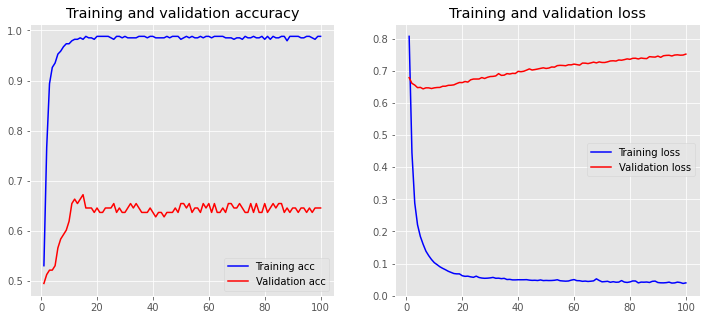

In [69]:
plot_history(history)

## LSTM for classification

In [70]:
max_features = 4000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['tags'].values)
X_rnn = tokenizer.texts_to_sequences(df['tags'].values)
X_rnn = sequence.pad_sequences(X_rnn)

In [71]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y, random_state = 22)

In [72]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train_rnn.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 128)           512000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 35, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 197       
Total params: 766,997
Trainable params: 766,997
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
batch_size = 4
history = model.fit(X_train_rnn, y_train_rnn,verbose=2 ,epochs = 10,validation_data=(X_test_rnn, y_test_rnn), batch_size=batch_size)

Epoch 1/10
85/85 - 14s - loss: 0.6764 - accuracy: 0.6136 - val_loss: 0.7175 - val_accuracy: 0.5310
Epoch 2/10
85/85 - 10s - loss: 0.5871 - accuracy: 0.6578 - val_loss: 0.6297 - val_accuracy: 0.5575
Epoch 3/10
85/85 - 10s - loss: 0.4652 - accuracy: 0.8525 - val_loss: 0.6722 - val_accuracy: 0.6549
Epoch 4/10
85/85 - 10s - loss: 0.2952 - accuracy: 0.8879 - val_loss: 0.7384 - val_accuracy: 0.6549
Epoch 5/10
85/85 - 10s - loss: 0.1756 - accuracy: 0.9322 - val_loss: 0.7290 - val_accuracy: 0.6018
Epoch 6/10
85/85 - 11s - loss: 0.1484 - accuracy: 0.9381 - val_loss: 0.8981 - val_accuracy: 0.6283
Epoch 7/10
85/85 - 10s - loss: 0.1159 - accuracy: 0.9676 - val_loss: 0.7749 - val_accuracy: 0.6460
Epoch 8/10
85/85 - 10s - loss: 0.0757 - accuracy: 0.9764 - val_loss: 0.9290 - val_accuracy: 0.6283
Epoch 9/10
85/85 - 10s - loss: 0.0707 - accuracy: 0.9735 - val_loss: 0.9348 - val_accuracy: 0.6637
Epoch 10/10
85/85 - 10s - loss: 0.0603 - accuracy: 0.9823 - val_loss: 0.9921 - val_accuracy: 0.6726


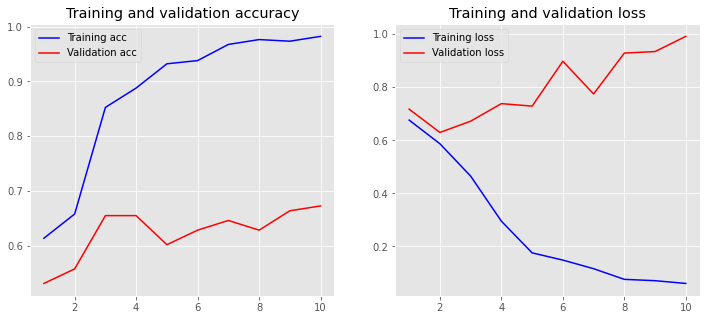

In [74]:
plot_history(history)

## Using tags and captions also to train the model for image classification

In [75]:
X = df['text']
y = df.iloc[:,-3]
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
vect = CountVectorizer(tokenizer=tokenize)
X = vect.fit_transform(X)

tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)
pipeline = Pipeline([('scale',StandardScaler(with_mean=False)),
                     ('clf', LinearSVC())])

search_space = [{'clf':[LinearSVC()]},
                
                {'clf': [LogisticRegression(solver='sag',random_state=22)]},
                
                {'clf': [MultinomialNB()]},
                {'clf':[RandomForestClassifier(n_estimators=200, max_depth=3, random_state=22)]}]

In [77]:
cv = GridSearchCV(pipeline, search_space)

In [78]:
cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=False,
                                                       with_std=True)),
                                       ('clf',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                               

In [80]:
pred = cv.predict(X_test)

In [81]:
print_accuracy(pred,y_test)

Accuracy:  0.6194690265486725


## Deep Learning model for Classification

In [82]:
x_train_array = X_train.toarray()
y_train_array = np.array(y_train)
x_test_array = X_test.toarray()
y_test_array = np.array(y_test)

In [83]:
input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [84]:
scaler = StandardScaler()
# transform data
x_train_array = scaler.fit_transform(x_train_array)
x_test_array = scaler.fit_transform(x_test_array)

In [85]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                42770     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 42,781
Trainable params: 42,781
Non-trainable params: 0
_________________________________________________________________


In [86]:
history = model.fit(x_train_array, y_train_array,epochs=100,verbose=False,validation_data=(x_test_array, y_test_array),batch_size=10)

In [87]:
loss, accuracy = model.evaluate(x_train_array, y_train_array, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test_array, y_test_array, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9587
Testing Accuracy:  0.6283


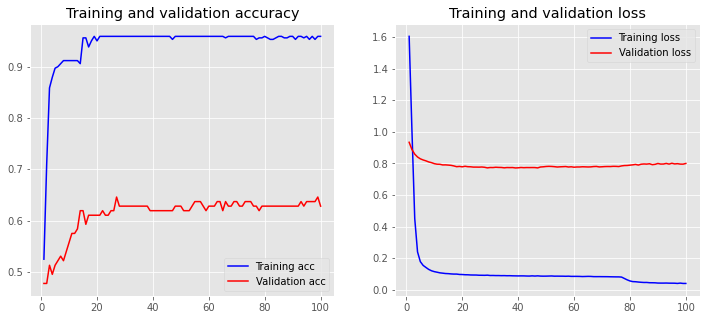

In [88]:
plot_history(history)

## LSTM for Classification

In [89]:
max_features = 4000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X_rnn = tokenizer.texts_to_sequences(df['text'].values)
X_rnn = sequence.pad_sequences(X_rnn)

In [90]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y, random_state = 22)

In [91]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train_rnn.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 295, 128)          512000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 295, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 197       
Total params: 766,997
Trainable params: 766,997
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
batch_size = 4
history = model.fit(X_train_rnn, y_train_rnn,verbose=2 ,epochs = 10,validation_data=(X_test_rnn, y_test_rnn), batch_size=batch_size)

Epoch 1/10
85/85 - 85s - loss: 0.6761 - accuracy: 0.6136 - val_loss: 0.6777 - val_accuracy: 0.5575
Epoch 2/10
85/85 - 82s - loss: 0.6017 - accuracy: 0.7050 - val_loss: 0.6297 - val_accuracy: 0.6283
Epoch 3/10
85/85 - 83s - loss: 0.4193 - accuracy: 0.8230 - val_loss: 0.6524 - val_accuracy: 0.6372
Epoch 4/10
85/85 - 83s - loss: 0.2389 - accuracy: 0.9322 - val_loss: 0.7764 - val_accuracy: 0.6814
Epoch 5/10
85/85 - 80s - loss: 0.1821 - accuracy: 0.9381 - val_loss: 0.9059 - val_accuracy: 0.6814
Epoch 6/10
85/85 - 81s - loss: 0.0951 - accuracy: 0.9676 - val_loss: 1.0231 - val_accuracy: 0.6726
Epoch 7/10
85/85 - 85s - loss: 0.0403 - accuracy: 0.9853 - val_loss: 1.0359 - val_accuracy: 0.6637
Epoch 8/10
85/85 - 82s - loss: 0.0405 - accuracy: 0.9912 - val_loss: 1.3676 - val_accuracy: 0.6726
Epoch 9/10
85/85 - 82s - loss: 0.0460 - accuracy: 0.9853 - val_loss: 0.9583 - val_accuracy: 0.6549
Epoch 10/10
85/85 - 85s - loss: 0.0334 - accuracy: 0.9882 - val_loss: 0.9843 - val_accuracy: 0.6549


In [93]:
loss, accuracy = model.evaluate(X_train_rnn, y_train_rnn, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_rnn, y_test_rnn, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9941
Testing Accuracy:  0.6549


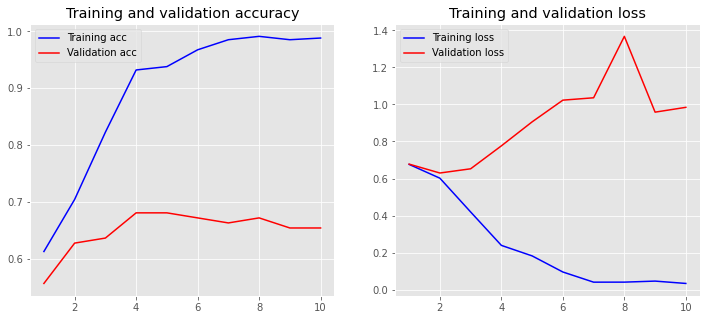

In [94]:
plot_history(history)

## Conclusion
### Dataset
1. The dataset is slighlty unbalanced as we can see there are more pavbhaji images then no pavbhaji.
2. The dataset contains hindi,english, hindi written words, emojis.
3. The dataset is very small with only 400 valid rows.

### ML Implementation results
1. As we can LSTM and deep neural network trained "tags and captions" gives a bit better results then using only "tags" and classical ML models.
2. We also saw test or validation loss was increasing in case of neural networks, this might be because of overfitting as we have very small dataset.

### Further things that we can try
1. Using POS TAGGING.
2. Handling the Hindi words separately.
3. Using images and creating latent feature vectors along with the textual features to classify the images.
4. I haven't used other features like 'edge_liked_by', 'edge_media_preview_like'. I thought these features would not add much to classification purpose. We can explore these features to find if they have any dependency in identifying a pav bhaji